In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, time
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor


In [7]:
df = pd.read_csv('Final_FLights_Cords.csv')
df.shape

(3000000, 36)

In [8]:
delay_columns = ['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'CANCELLATION_CODE']

df[delay_columns] = df[delay_columns].fillna(0).infer_objects(copy=False)

In [9]:
df = df.dropna(subset=['ARR_DELAY'])

In [10]:
columns_to_drop = ['d_longitude','d_latitude', 'o_longitude' , 'o_latitude','CANCELLED','CANCELLATION_CODE', 'DIVERTED', 'AIRLINE', 'AIRLINE_DOT', 'ORIGIN_CITY', 'DEST_CITY']
df = df.drop(columns=columns_to_drop)

In [11]:
df.columns

Index(['FL_DATE', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
       'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT'],
      dtype='object')

In [12]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

In [13]:
df['MONTH'] = df['FL_DATE'].dt.month
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek

In [14]:
def convert_to_hhmm(time_value):
    if isinstance(time_value, str) and len(time_value) == 4:
        return time_value
    elif pd.isnull(time_value):
        return '0000'
    elif isinstance(time_value, (int, float)):
        return f"{int(time_value):04d}"
    elif isinstance(time_value, time):
        return time_value.strftime('%H%M')
    else:
        raise ValueError("Unexpected time format")

In [15]:
df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(convert_to_hhmm)
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].apply(convert_to_hhmm)

In [16]:
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'].str[:2].astype(int)
df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'].str[:2].astype(int)

In [17]:
import calendar
df['MONTH_NAME'] = df['MONTH'].apply(lambda x: calendar.month_name[x])

# Convert numeric day of week to day name
df['DAY_NAME'] = df['DAY_OF_WEEK'].apply(lambda x: calendar.day_name[x-1])

# Drop the original numeric columns if no longer needed
df.drop(['MONTH', 'DAY_OF_WEEK'], axis=1, inplace=True)

In [18]:
df.head(2)

,FL_DATE,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,...,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,CRS_DEP_HOUR,CRS_ARR_HOUR,MONTH_NAME,DAY_NAME
0,2019-01-09,UA,19977,1562,FLL,EWR,1155,1151.0,-4.0,19.0,...,1065.0,0.0,0.0,0.0,0.0,0.0,11,15,January,Tuesday
1,2022-11-19,DL,19790,1149,MSP,SEA,2120,2114.0,-6.0,9.0,...,1399.0,0.0,0.0,0.0,0.0,0.0,21,23,November,Friday


In [19]:
delay_threshold = 15
df['DELAYED'] = (df['ARR_DELAY'] > delay_threshold).astype(int)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2913802 entries, 0 to 2999999
Data columns (total 30 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE_CODE             object        
 2   DOT_CODE                 int64         
 3   FL_NUMBER                int64         
 4   ORIGIN                   object        
 5   DEST                     object        
 6   CRS_DEP_TIME             object        
 7   DEP_TIME                 float64       
 8   DEP_DELAY                float64       
 9   TAXI_OUT                 float64       
 10  WHEELS_OFF               float64       
 11  WHEELS_ON                float64       
 12  TAXI_IN                  float64       
 13  CRS_ARR_TIME             object        
 14  ARR_TIME                 float64       
 15  ARR_DELAY                float64       
 16  CRS_ELAPSED_TIME         float64       
 17  ELAPSED_TIME             float64

In [21]:
def determine_delay_reason(row):
    reasons = []
    if row['DELAY_DUE_CARRIER'] > 0:
        reasons.append('CARRIER')
    if row['DELAY_DUE_WEATHER'] > 0:
        reasons.append('WEATHER')
    if row['DELAY_DUE_NAS'] > 0:
        reasons.append('NAS')
    if row['DELAY_DUE_SECURITY'] > 0:
        reasons.append('SECURITY')
    if row['DELAY_DUE_LATE_AIRCRAFT'] > 0:
        reasons.append('LATE_AIRCRAFT')
    
    if len(reasons) > 0:
        return ', '.join(reasons)
    else:
        return 'NO_DELAY'



In [22]:
df['DELAY_REASON'] = df.apply(determine_delay_reason, axis=1)

In [23]:
df.isnull().sum()

FL_DATE                    0
AIRLINE_CODE               0
DOT_CODE                   0
FL_NUMBER                  0
ORIGIN                     0
DEST                       0
CRS_DEP_TIME               0
DEP_TIME                   0
DEP_DELAY                  0
TAXI_OUT                   0
WHEELS_OFF                 0
WHEELS_ON                  0
TAXI_IN                    0
CRS_ARR_TIME               0
ARR_TIME                   0
ARR_DELAY                  0
CRS_ELAPSED_TIME           0
ELAPSED_TIME               0
AIR_TIME                   0
DISTANCE                   0
DELAY_DUE_CARRIER          0
DELAY_DUE_WEATHER          0
DELAY_DUE_NAS              0
DELAY_DUE_SECURITY         0
DELAY_DUE_LATE_AIRCRAFT    0
CRS_DEP_HOUR               0
CRS_ARR_HOUR               0
MONTH_NAME                 0
DAY_NAME                   0
DELAYED                    0
DELAY_REASON               0
dtype: int64

In [24]:
df[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                  'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_REASON']].head(200)

,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAY_REASON
0,0.0,0.0,0.0,0.0,0.0,NO_DELAY
1,0.0,0.0,0.0,0.0,0.0,NO_DELAY
2,0.0,0.0,0.0,0.0,0.0,NO_DELAY
3,0.0,0.0,24.0,0.0,0.0,NAS
4,0.0,0.0,0.0,0.0,0.0,NO_DELAY
...,...,...,...,...,...,...
199,0.0,2.0,16.0,0.0,5.0,"WEATHER, NAS, LATE_AIRCRAFT"
200,0.0,0.0,0.0,0.0,0.0,NO_DELAY
201,0.0,0.0,0.0,0.0,0.0,NO_DELAY
202,0.0,0.0,0.0,0.0,0.0,NO_DELAY


In [26]:
df.to_csv('Cleaned.csv')

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
df['DELAY_REASON'] = df['DELAY_REASON'].astype(str)


df['DELAY_REASON'] = df['DELAY_REASON'].str.split(', ')

mlb = MultiLabelBinarizer()
delay_reasons_encoded = pd.DataFrame(mlb.fit_transform(df['DELAY_REASON']), columns=mlb.classes_, index=df.index)

df = pd.concat([df, delay_reasons_encoded], axis=1)

In [28]:
df[['DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                  'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_REASON', 'LATE_AIRCRAFT', 'NAS','NO_DELAY','SECURITY','WEATHER']].head(200)

,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,DELAY_REASON,LATE_AIRCRAFT,NAS,NO_DELAY,SECURITY,WEATHER
0,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0
1,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0
3,0.0,0.0,24.0,0.0,0.0,[NAS],0,1,0,0,0
4,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
199,0.0,2.0,16.0,0.0,5.0,"[WEATHER, NAS, LATE_AIRCRAFT]",1,1,0,0,1
200,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0
201,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0
202,0.0,0.0,0.0,0.0,0.0,[NO_DELAY],0,0,1,0,0


In [29]:
columns_to_drop = ['DELAY_REASON', 'ARR_TIME', 'DEP_TIME', 'DOT_CODE', 'FL_DATE' ]

df = df.drop(columns=columns_to_drop) 

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2913802 entries, 0 to 2999999
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   AIRLINE_CODE             object 
 1   FL_NUMBER                int64  
 2   ORIGIN                   object 
 3   DEST                     object 
 4   CRS_DEP_TIME             object 
 5   DEP_DELAY                float64
 6   TAXI_OUT                 float64
 7   WHEELS_OFF               float64
 8   WHEELS_ON                float64
 9   TAXI_IN                  float64
 10  CRS_ARR_TIME             object 
 11  ARR_DELAY                float64
 12  CRS_ELAPSED_TIME         float64
 13  ELAPSED_TIME             float64
 14  AIR_TIME                 float64
 15  DISTANCE                 float64
 16  DELAY_DUE_CARRIER        float64
 17  DELAY_DUE_WEATHER        float64
 18  DELAY_DUE_NAS            float64
 19  DELAY_DUE_SECURITY       float64
 20  DELAY_DUE_LATE_AIRCRAFT  float64
 21  CRS_DEP_HOUR 

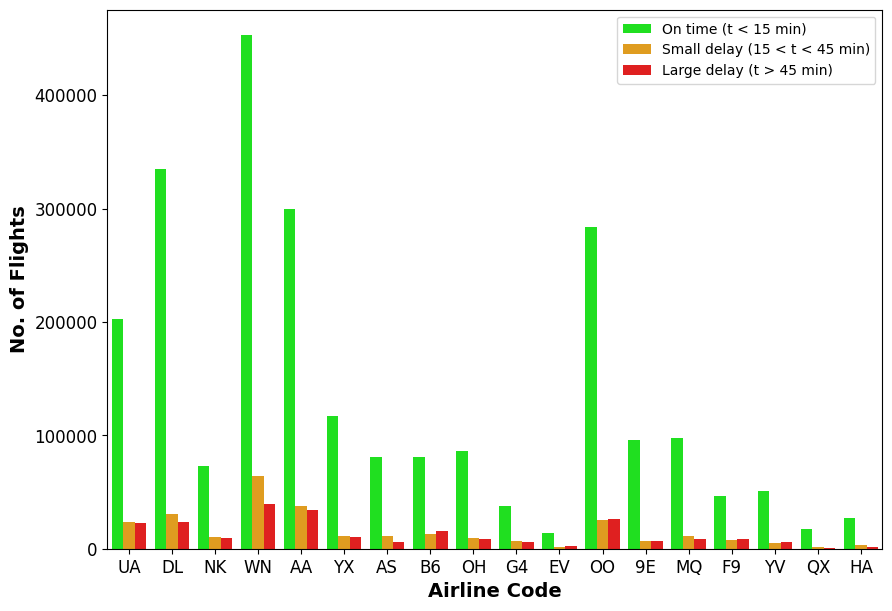

In [31]:
delay_level = lambda x: ((0, 1)[x > 15], 2)[x > 45]

# Apply the delay_level function to create a new column 'ARR_DELAY_LEVEL'
df['ARR_DELAY_LEVEL'] = df['ARR_DELAY'].apply(delay_level)

# Set up the figure and axis
fig = plt.figure(figsize=(10, 7))
ax = sns.countplot(x="AIRLINE_CODE", hue='ARR_DELAY_LEVEL', data=df,
                   palette=["#00FF00", "#FFA500", "#FF0000"])

# Customize labels and ticks
ax.set_xlabel('Airline Code', fontsize=14, weight='bold')
ax.set_ylabel('No. of Flights', fontsize=14, weight='bold')
ax.tick_params(axis='both', which='major', labelsize=12)

# Customize legend labels
L = plt.legend()
L.get_texts()[0].set_text('On time (t < 15 min)')
L.get_texts()[1].set_text('Small delay (15 < t < 45 min)')
L.get_texts()[2].set_text('Large delay (t > 45 min)')

# Show plot
plt.show()

C:\Users\mamoo\AppData\Local\Temp\ipykernel_8260\1531615337.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='', loc='upper right')


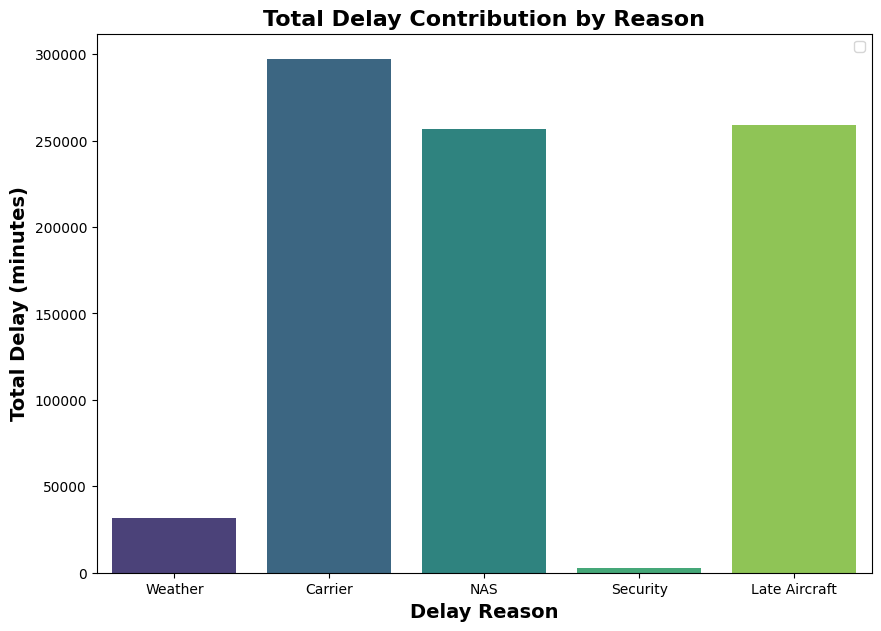

In [32]:
total_weather_delay = df['WEATHER'].sum()
total_carrier_delay = df['CARRIER'].sum()
total_nas_delay = df['NAS'].sum()
total_security_delay = df['SECURITY'].sum()
total_late_aircraft_delay = df['LATE_AIRCRAFT'].sum()

# Create a bar plot
reasons = ['Weather', 'Carrier', 'NAS', 'Security', 'Late Aircraft']
totals = [total_weather_delay, total_carrier_delay, total_nas_delay, total_security_delay, total_late_aircraft_delay]

plt.figure(figsize=(10, 7))
sns.barplot(x=reasons, y=totals, hue=reasons, palette='viridis', dodge=False)
plt.xlabel('Delay Reason', fontsize=14, weight='bold')
plt.ylabel('Total Delay (minutes)', fontsize=14, weight='bold')
plt.title('Total Delay Contribution by Reason', fontsize=16, weight='bold')
plt.legend(title='', loc='upper right')
plt.show()

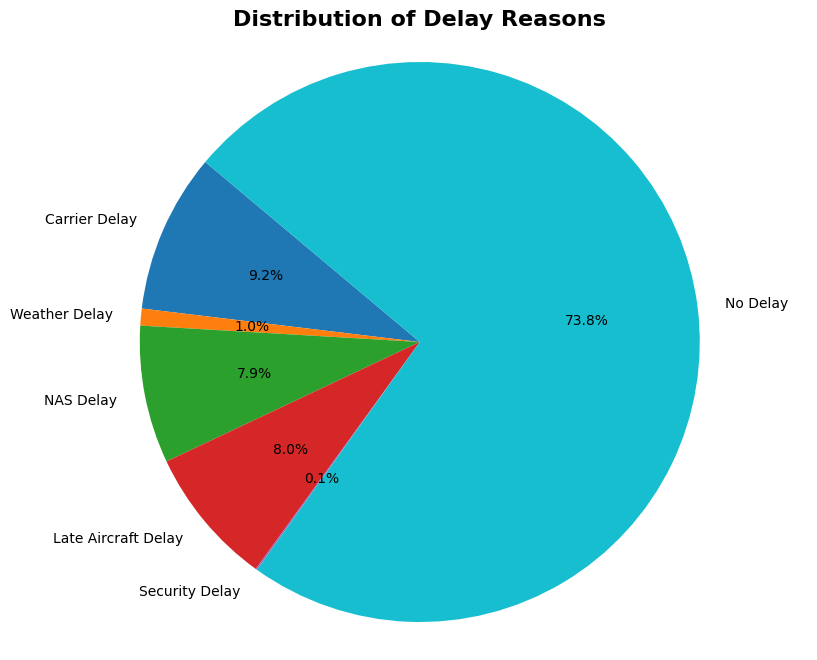

In [33]:
import matplotlib.pyplot as plt

carrier_delay = df['CARRIER'].sum()
weather_delay = df['WEATHER'].sum()
nas_delay = df['NAS'].sum()
late_aircraft_delay = df['LATE_AIRCRAFT'].sum()
security_delay = df['SECURITY'].sum()
no_delay = df['NO_DELAY'].sum()


labels = ['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Late Aircraft Delay', 'Security Delay', 'No Delay']
sizes = [carrier_delay, weather_delay, nas_delay, late_aircraft_delay, security_delay, no_delay]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#17becf'] 


plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Delay Reasons', fontsize=16, weight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

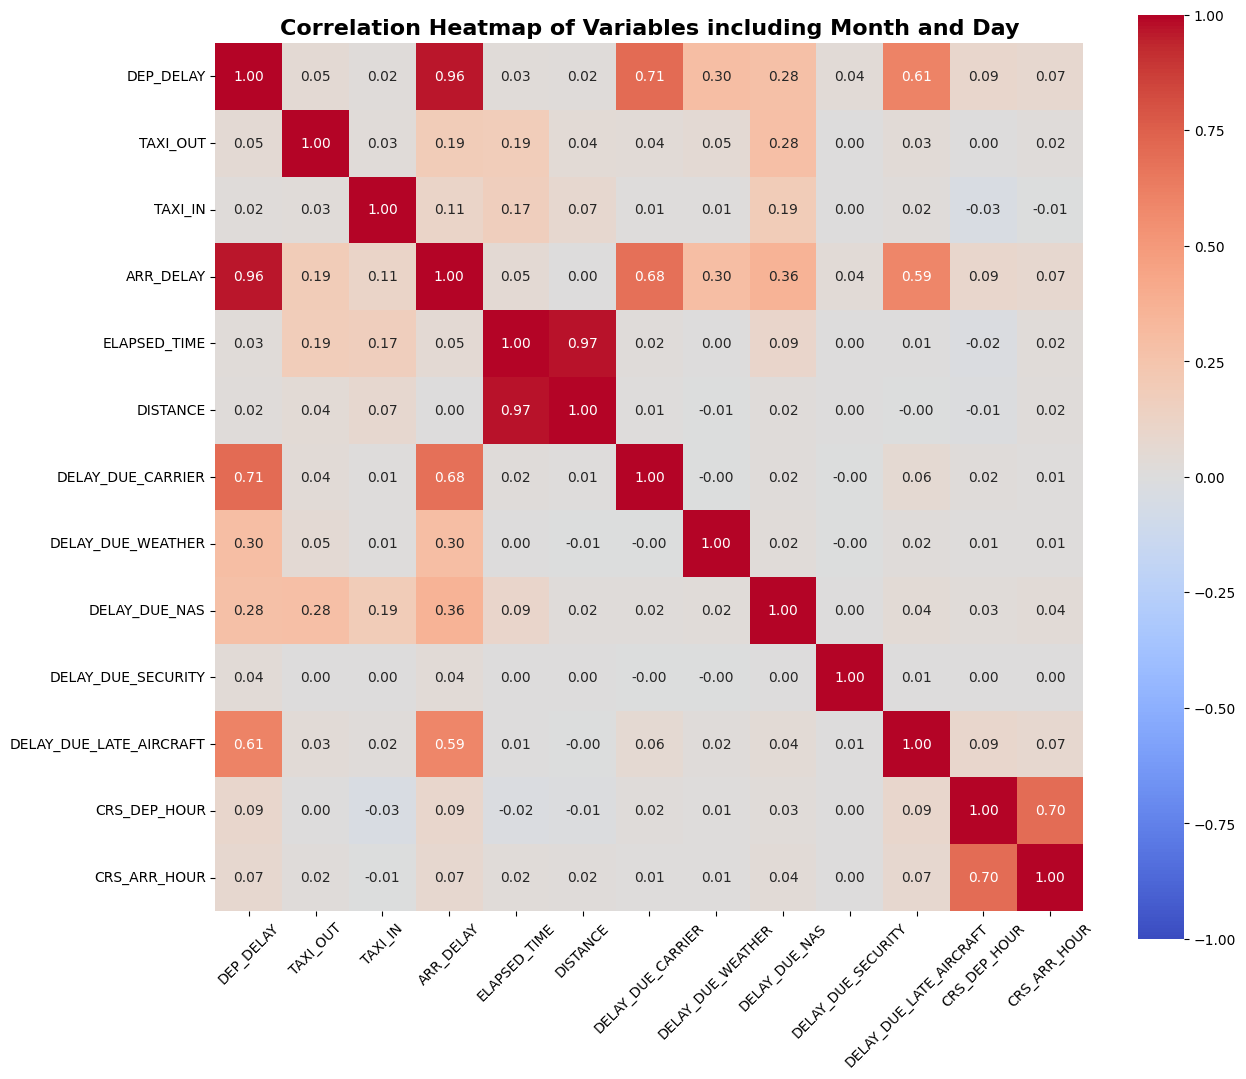

In [34]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()


# Selecting columns for correlation analysis
columns_of_interest = ['DEP_DELAY', 'TAXI_OUT', 'TAXI_IN', 'ARR_DELAY', 'ELAPSED_TIME',
                       'DISTANCE', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS',
                       'DELAY_DUE_SECURITY', 'DELAY_DUE_LATE_AIRCRAFT', 
                       'CRS_DEP_HOUR', 'CRS_ARR_HOUR']

# Calculate correlation matrix
corr_matrix = df[columns_of_interest].corr()

# Plotting the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, square=True)
plt.title('Correlation Heatmap of Variables including Month and Day', fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [35]:
delayed_data = df[df['DELAYED'] == 1]


In [36]:
features = ['AIRLINE_CODE', 'FL_NUMBER', 'ORIGIN', 'DEST',
            'DEP_DELAY', 'CRS_ELAPSED_TIME',
            'DISTANCE', 'CRS_DEP_HOUR', 'CRS_ARR_HOUR', 'MONTH_NAME', 'DAY_NAME']

target_variables = ['CARRIER', 'LATE_AIRCRAFT', 'NAS', 'SECURITY', 'WEATHER']


X_reasons = delayed_data[features]
y_reasons = delayed_data[target_variables]

X_train, X_test, y_train, y_test = train_test_split(X_reasons, y_reasons, test_size=0.2, random_state=42)

In [37]:
from sklearn.impute import SimpleImputer
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, ['FL_NUMBER', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_HOUR', 'CRS_ARR_HOUR']),
        ('cat', categorical_transformer, ['AIRLINE_CODE', 'ORIGIN', 'DEST', 'MONTH_NAME', 'DAY_NAME'])
    ])

In [38]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
classifier = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier)])

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)




In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))



Accuracy Score: 0.28751770847483943
Precision Score: 0.6331682752241772
Recall Score: 0.6715138434148512
F1 Score: 0.6472380586309425


In [40]:
from sklearn.metrics import multilabel_confusion_matrix

# Calculate multilabel confusion matrix
multilabel_cm = multilabel_confusion_matrix(y_test, y_pred)

# Print confusion matrix for each label
for i, label in enumerate(target_variables):
    print(f"Confusion Matrix for {label}:")
    print(multilabel_cm[i])

# Additional evaluation metrics for multi-label classification
# Example: Hamming Loss
from sklearn.metrics import hamming_loss

hamming_loss_value = hamming_loss(y_test, y_pred)
print(f"\nHamming Loss: {hamming_loss_value}")

Confusion Matrix for CARRIER:
[[20864 24400]
 [14138 43656]]
Confusion Matrix for LATE_AIRCRAFT:
[[35556 17114]
 [16858 33530]]
Confusion Matrix for NAS:
[[36894 17129]
 [16092 32943]]
Confusion Matrix for SECURITY:
[[102545      2]
 [   509      2]]
Confusion Matrix for WEATHER:
[[96737    36]
 [ 6279     6]]

Hamming Loss: 0.21843427972597954


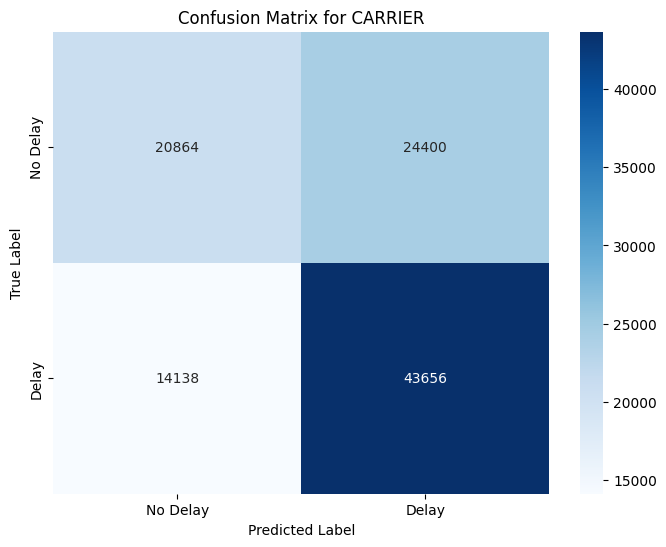

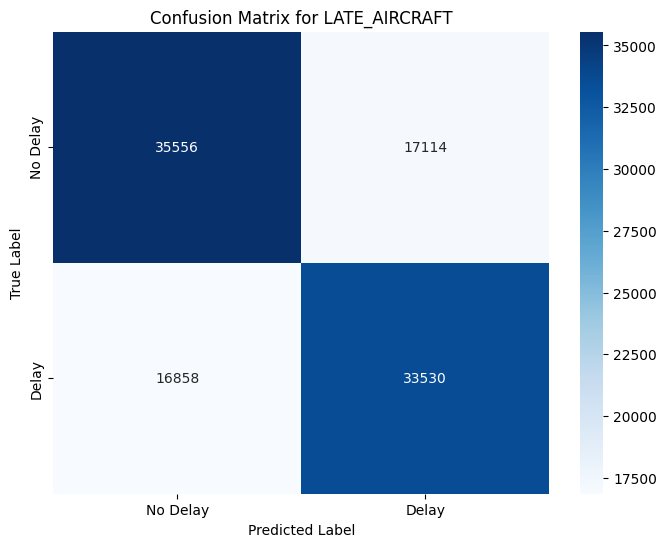

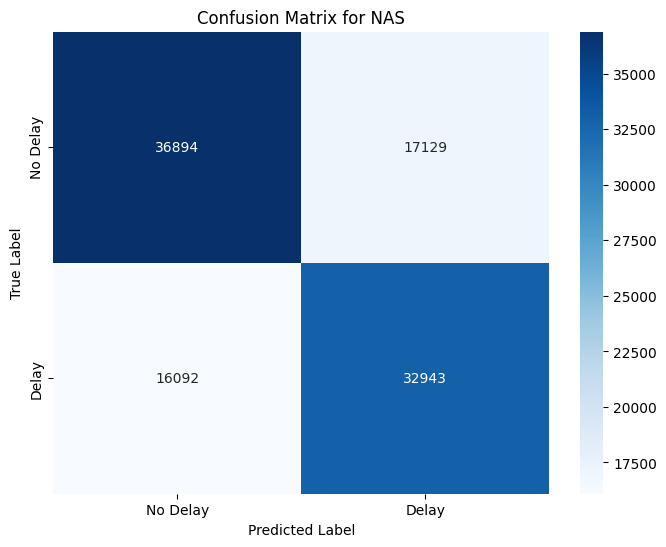

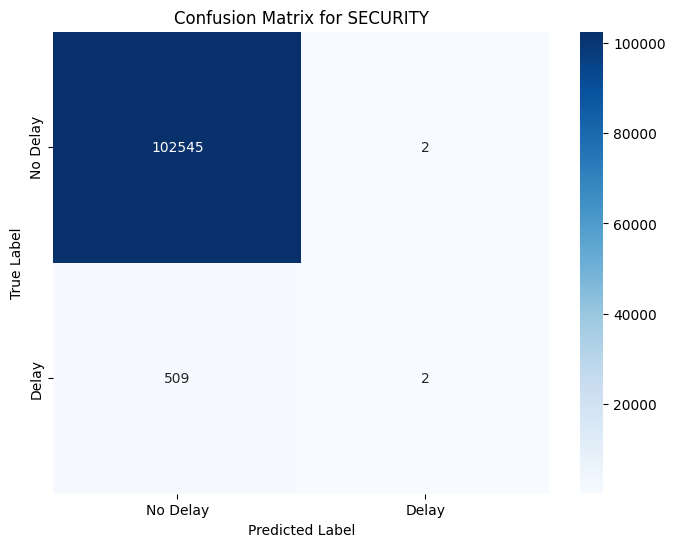

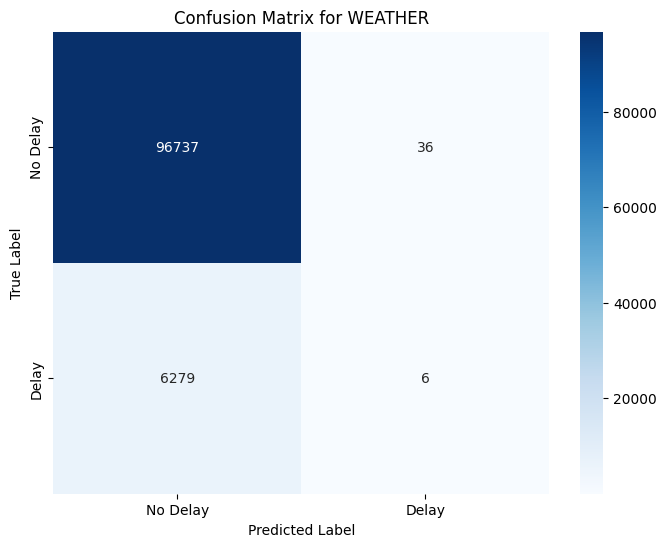

In [41]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['No Delay', 'Delay'], yticklabels=['No Delay', 'Delay'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
delay_reasons = ['CARRIER', 'LATE_AIRCRAFT', 'NAS', 'SECURITY', 'WEATHER']
for reason in delay_reasons:
    plot_confusion_matrix(y_test[reason], y_pred[:, delay_reasons.index(reason)], f'Confusion Matrix for {reason}')

In [51]:
from xgboost import XGBClassifier
classifier2 = MultiOutputClassifier(XGBClassifier(random_state=42))

# Create and fit the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', classifier2)])

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

In [52]:
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Precision Score:", precision_score(y_test, y_pred, average='weighted'))
print("Recall Score:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


Accuracy Score: 0.4340856605018533
Precision Score: 0.7366003452316005
Recall Score: 0.7343808112771548
F1 Score: 0.714954941487478


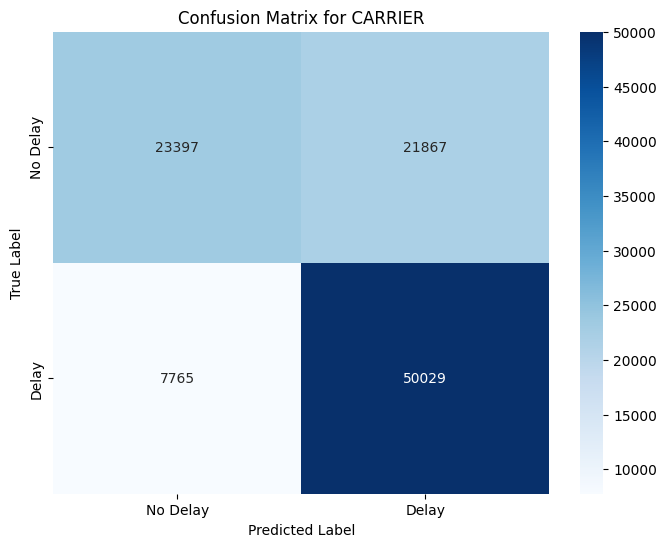

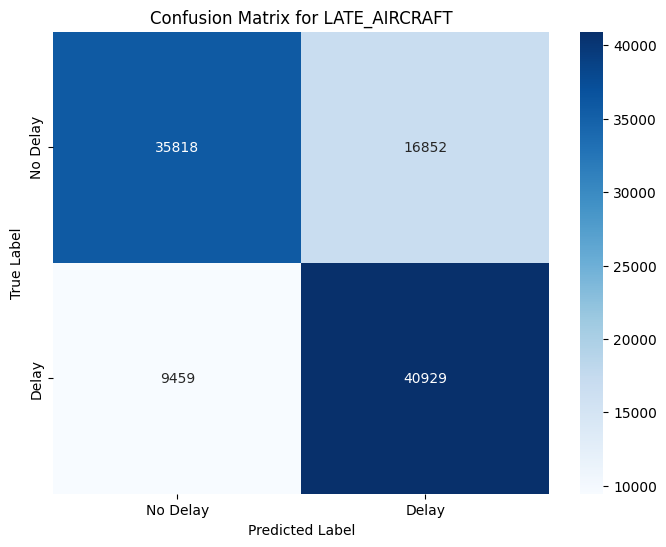

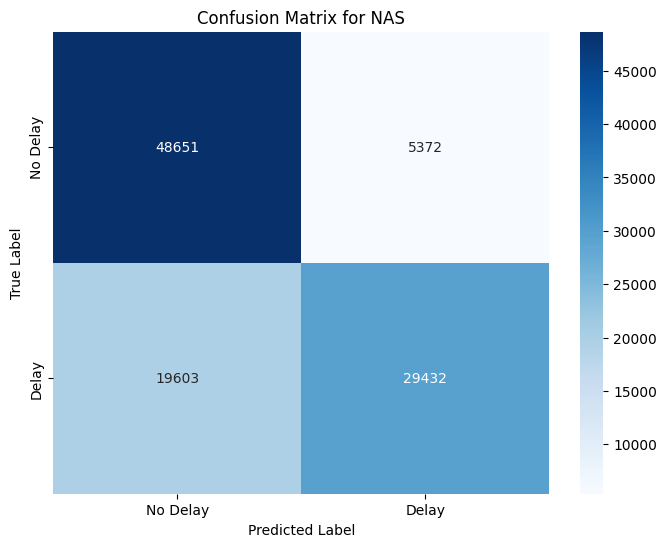

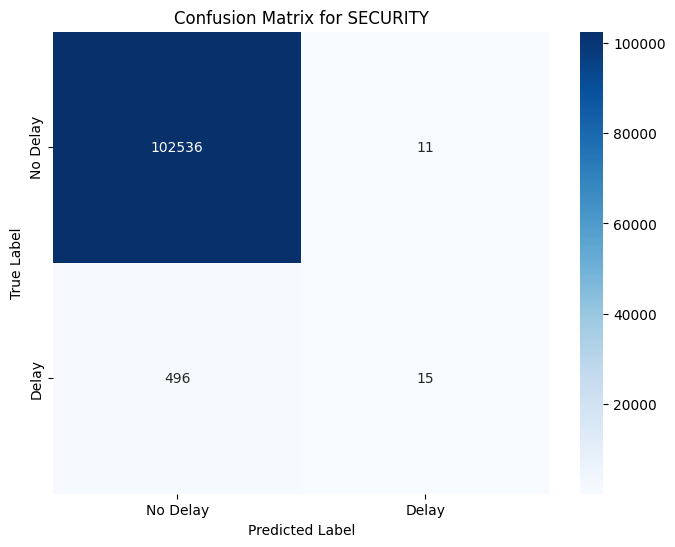

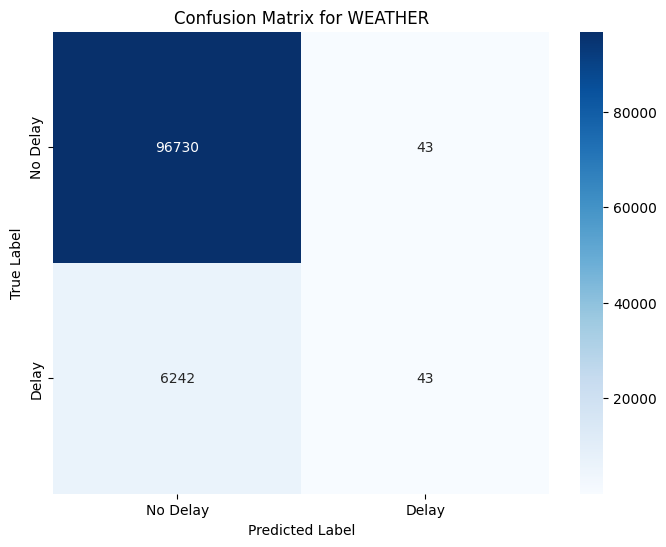

In [53]:
for reason in delay_reasons:
    plot_confusion_matrix(y_test[reason], y_pred[:, delay_reasons.index(reason)], f'Confusion Matrix for {reason}')